In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)

24/07/07 19:30:57 WARN Utils: Your hostname, MacBook-Pro-Sunith.local resolves to a loopback address: 127.0.0.1; using 10.10.67.28 instead (on interface en0)
24/07/07 19:30:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/07 19:30:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/07 19:30:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 56456)
Traceback (most recent call last):
  File "/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/pyspark/accumulators.py", l

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
file_path = 'data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Some house cleaning where the the column names are standardized

for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumnRenamed('days_for_shipping_(real)', 'actual_time')
df = df.withColumnRenamed('days_for_shipment_(scheduled)', 'predicted_time')

In [4]:
from pyspark.sql.functions import year, month, dayofmonth
df = df.withColumn("o_year", year(df["order_date"])) \
       .withColumn("o_month", month(df["order_date"])) \
       .withColumn("o_day", dayofmonth(df["order_date"]))

df = df.withColumn("s_year", year(df["shipping_date"])) \
       .withColumn("s_month", month(df["shipping_date"])) \
       .withColumn("s_day", dayofmonth(df["shipping_date"]))

In [5]:
df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)",
             'days_for_shipment_(scheduled)', 'days_for_shipping_(real)')    
df.createOrReplaceTempView("my_table")
df.show(5)

24/07/07 19:31:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-----------+--------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+------+-------+-----+------+-------+-----+
|    type|actual_time|predicted_time|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_na

In [47]:
country_list = spark.sql("""Select
        market,
        order_region, order_country, order_city,
        product_card_id,
        from my_table
        group by 
        order by quantity desc
        """).toPandas()
country_list

AnalysisException: [UNRESOLVED_COLUMN.WITHOUT_SUGGESTION] A column or function parameter with name `market` cannot be resolved. ; line 2 pos 8;
'Sort ['quantity DESC NULLS LAST], true
+- 'Aggregate ['product_name, 'product_card_id], ['market, 'order_region, 'order_country, 'order_city, 'from AS my_table#4782]
   +- OneRowRelation


In [6]:
product_list = spark.sql("""Select
          product_name, product_card_id,
          sum(order_item_quantity) as quantity
          from my_table
          group by product_name, product_card_id
          order by quantity desc
          """).toPandas()
product_list

,product_name,product_card_id,quantity
0,Perfect Fitness Perfect Rip Deck,365,73698
1,Nike Men's Dri-FIT Victory Golf Polo,502,62956
2,O'Brien Men's Neoprene Life Vest,1014,57803
3,Nike Men's Free 5.0+ Running Shoe,191,36680
4,Under Armour Girls' Toddler Spine Surge Runni,627,31735
...,...,...,...
113,Stiga Master Series ST3100 Competition Indoor,127,27
114,SOLE E35 Elliptical,208,15
115,Bushnell Pro X7 Jolt Slope Rangefinder,860,11
116,SOLE E25 Elliptical,60,10


Setting up the tables/views necessary for the forecasting

In [41]:
prophet_df = spark.sql("""
                       Select order_date as ds,
                       sum(order_item_quantity) as y
                       From my_table
                       Where product_card_id = 191
                       AND order_date <= '2016-06-01' 
                       and order_country = 'Estados Unidos'
                       group by ds
                       order by ds
                       """).toPandas()
prophet_df

,ds,y
0,2016-04-01,5
1,2016-04-02,29
2,2016-04-03,45
3,2016-04-04,23
4,2016-04-05,48
...,...,...
57,2016-05-28,20
58,2016-05-29,43
59,2016-05-30,32
60,2016-05-31,21


In [42]:
spark.sql("""
            CREATE OR REPLACE TEMPORARY VIEW actual AS
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = 191
            and order_country = 'Estados Unidos'
            AND order_date > '2016-06-01' 
            group by ds
            order by ds
        """)
# actual.show(5)
spark.sql('select * from actual').show(5)

+----------+---+
|        ds|  y|
+----------+---+
|2016-06-02| 31|
|2016-06-03| 29|
|2016-06-04| 40|
|2016-06-05| 29|
|2016-06-06| 22|
+----------+---+
only showing top 5 rows



## With Prophet

In [43]:
from prophet import Prophet
prophet = Prophet()

prophet.add_country_holidays(country_name='US')

prophet.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
future = prophet.make_future_dataframe(periods=120, freq='D')

# Generate forecasts
forecast = prophet.predict(future) 

20:05:23 - cmdstanpy - INFO - Chain [1] start processing
20:05:23 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
spark_df = spark.createDataFrame(forecast)
spark_df.createOrReplaceTempView("predicted")
spark.sql("""
          CREATE OR REPLACE TEMPORARY VIEW predicted_filter AS
          Select ds, yhat
          from predicted
          """)
results = spark.sql("""
          select p.*, a.y
          from predicted_filter as p
          left join actual as a on a.ds = p.ds
          """).toPandas()


In [45]:
results

,ds,yhat,y
0,2016-04-01,33.776786,NaN
1,2016-04-02,34.890132,NaN
2,2016-04-03,39.347212,NaN
3,2016-04-04,38.702226,NaN
4,2016-04-05,32.434352,NaN
...,...,...,...
177,2016-09-25,22.279565,NaN
178,2016-09-26,21.634579,NaN
179,2016-09-27,15.366705,NaN
180,2016-09-28,21.049819,NaN


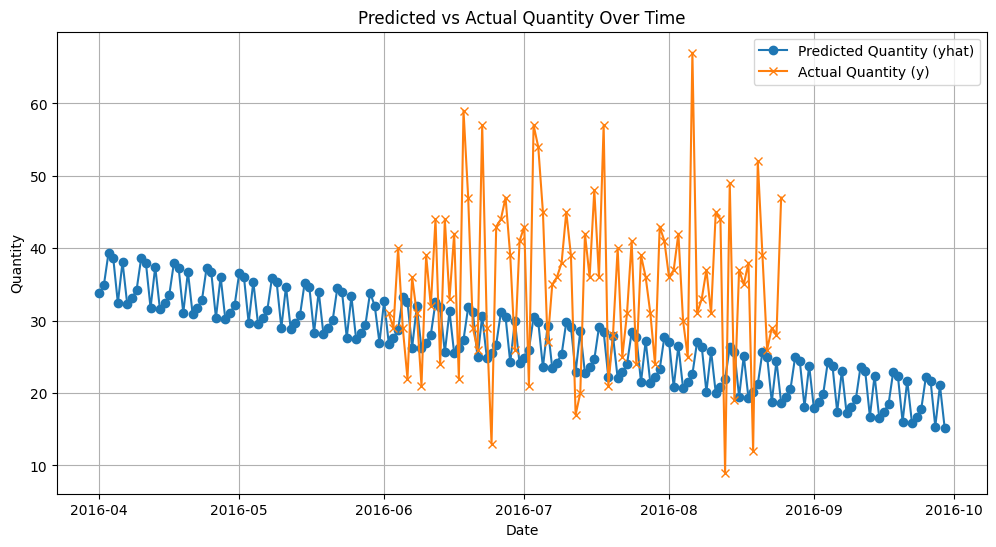

In [46]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(results['ds'], results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [23]:
prophet.train_holiday_names

0                  New Year's Day
1                    Memorial Day
2                Independence Day
3                       Labor Day
4                    Veterans Day
5                    Thanksgiving
6                   Christmas Day
7        Christmas Day (observed)
8      Martin Luther King Jr. Day
9           Washington's Birthday
10                   Columbus Day
11    Independence Day (observed)
dtype: object

In [38]:
results1 = spark.sql("""
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = 191
            and order_country = 'Estados Unidos'
            group by ds
            order by ds
        """).toPandas()
results1

,ds,y
0,2016-04-01,5
1,2016-04-02,29
2,2016-04-03,45
3,2016-04-04,23
4,2016-04-05,48
...,...,...
142,2016-08-21,39
143,2016-08-22,26
144,2016-08-23,29
145,2016-08-24,28


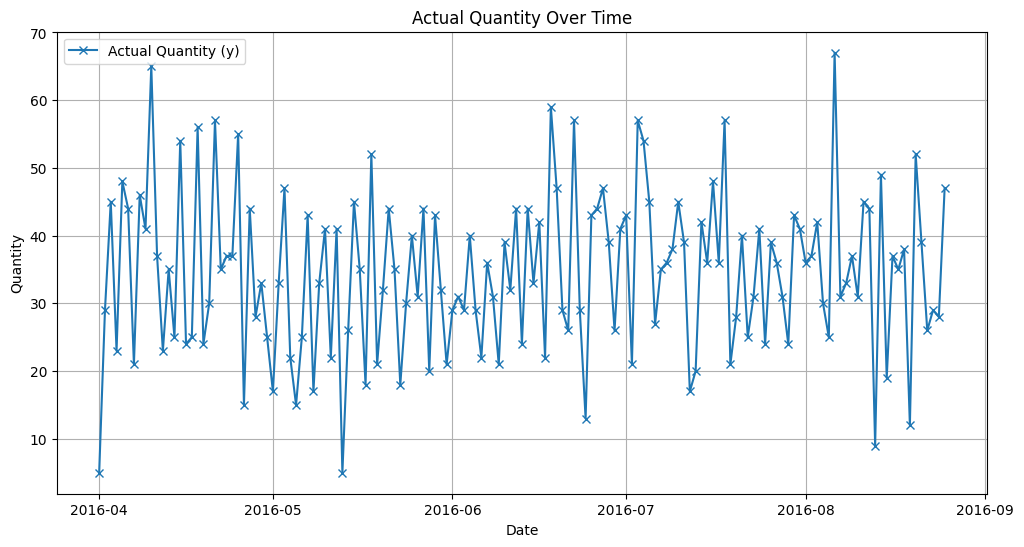

In [39]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results1['ds'], results1['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

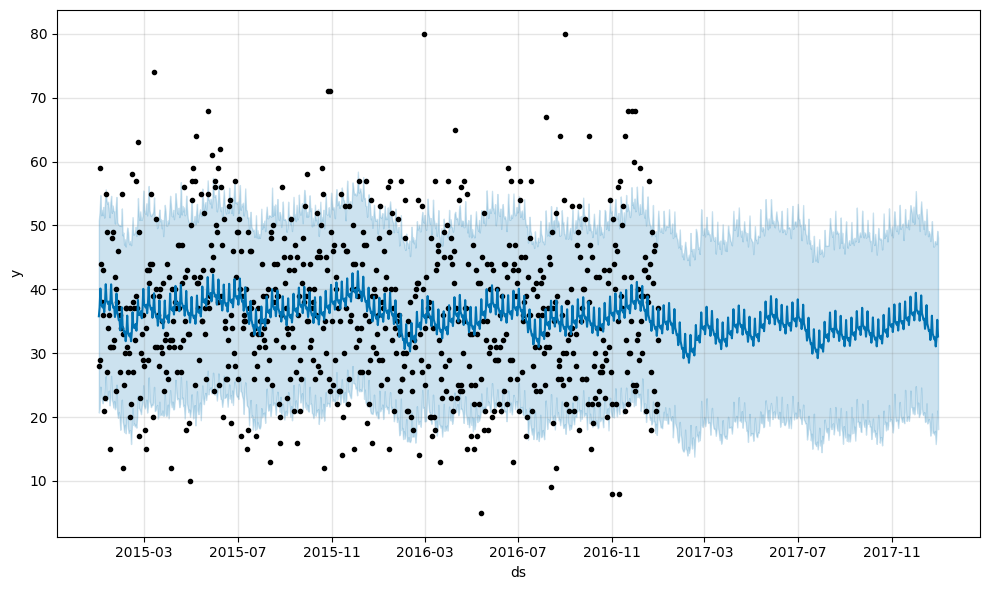

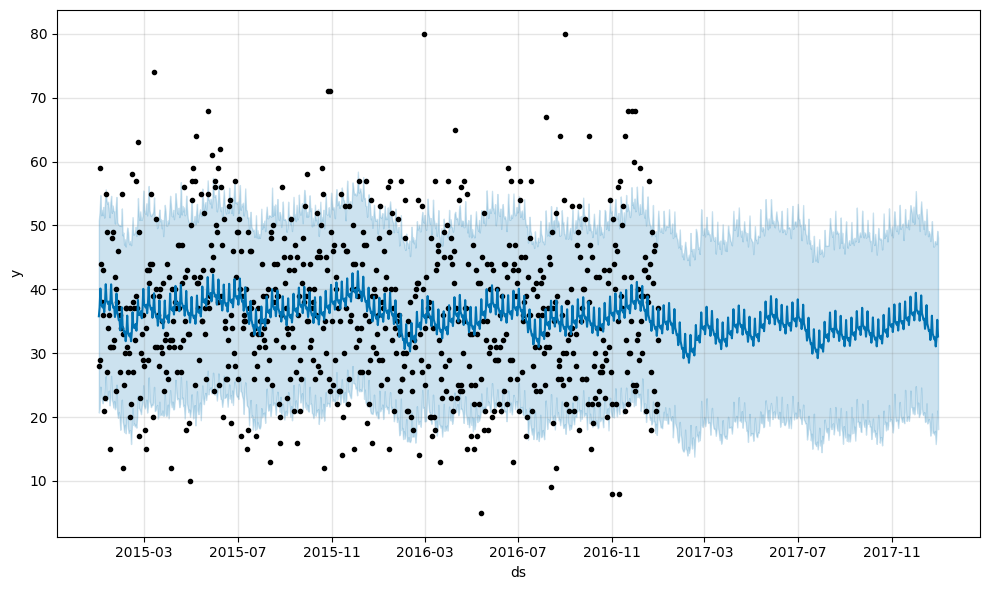

In [60]:
import warnings

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot the forecast
prophet.plot(forecast)

## Exponential Smoothing

In [63]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [94]:
actual_expo = spark.sql('select * from actual')
actual_expo = actual_expo.toPandas()
actual_expo

,ds,y
0,2017-01-01,44
1,2017-01-02,45
2,2017-01-03,24
3,2017-01-04,41
4,2017-01-05,40
...,...,...
270,2017-09-28,51
271,2017-09-29,30
272,2017-09-30,32
273,2017-10-01,46


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create DataFrame
# df = pd.DataFrame(data)
df = prophet_df

# Set ds as the index
# df.set_index('ds', inplace=True)

# Fit the model
model = ExponentialSmoothing(df['y'], trend='add', seasonal=None, seasonal_periods=None)
fit = model.fit()

# Make predictions
df['yhat'] = fit.fittedvalues

# Forecast future values (e.g., for the next 5 periods)
forecast_steps = 5
forecast = fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({
    'ds': forecast_dates,
    'yhat': forecast
})

# Reset index for concatenation
df = df.reset_index()

# Combine actual, fitted, and forecast values for plotting
combined_df = pd.concat([df, forecast_df], ignore_index=True)

/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [121]:
spark_df_expo = spark.createDataFrame(combined_df)
spark_df_expo.createOrReplaceTempView("expo_pred")


In [135]:
spark.sql("""
          CREATE OR REPLACE TEMPORARY VIEW pred_expo AS
          select DATE_FORMAT(CAST(ds AS DATE), 'yyyy-MM-dd') AS ds,
          yhat 
          from expo_pred
          """)

DataFrame[]

In [139]:
expo_results = spark.sql("""
          select p.ds, a.y, p.yhat
          from pred_expo as p
          inner join actual as a on a.ds = p.ds
          """).toPandas()

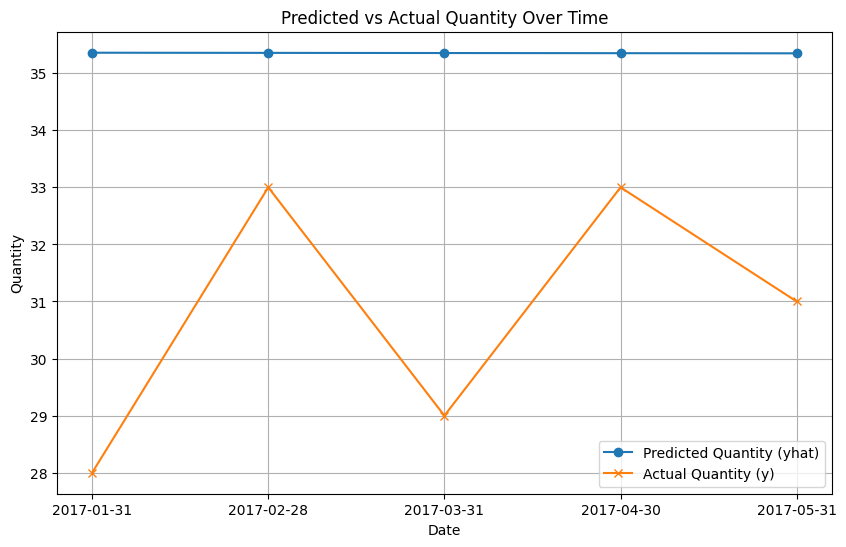

In [140]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(expo_results['ds'], expo_results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(expo_results['ds'], expo_results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()